In [ ]:
!pip install --quiet transformers
!pip install --quiet torchinfo
!pip install --quiet gdown
!pip install --quiet clean-text
!pip install --quiet wget
!pip install --quiet openai
!pip install --upgrade openai

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#open ai
import openai
# others
import re, string
import emoji
import pandas as pd
import numpy as np
import traceback
import torch.nn.functional as F
from tqdm import tqdm
from collections import defaultdict

from transformers import AutoModel, AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import BertTokenizer

import wget
import openai
import torch
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
openai.api_key = ""
!export OPENAI_API_KEY=""

In [ ]:
test = pd.read_csv('/content/test.csv')
id2label = {0:'non-toxic', 1:'mild', 2:'toxic'}

In [ ]:
def print_default_confusion_matrix(model_name, tests, predictions):
  data_labels = ['non-toxic', 'mild', 'toxic']

  default_conf_mx = confusion_matrix(tests, predictions)
  print(f'{model_name} confusion matrix log:')
  print(default_conf_mx)

def print_confusion_matrix(model_name, tests, predictions):
  data_labels = ['non-toxic', 'mild', 'toxic']

  conf_mx = confusion_matrix(tests, predictions, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=data_labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title(f"{model_name} normalized confusion matrix")
  plt.show()

def print_classification_report(tests, predictions):
  class_names = ['non-toxic','mild', 'toxic']
  print(classification_report(tests, predictions, target_names=class_names))

In [ ]:
def gpt3_classify(text):
  input_prompt = text + ' ->'
  fine_tuned_model_id = 'ft:davinci-002:personal:gpt-dota-toxic:7uKhQqc5'
  res = openai.Completion.create(model=fine_tuned_model_id, prompt=input_prompt, max_tokens=2, temperature=0)
  output = res['choices'][0]['text'].strip()
  #return {id2label[int(output)]}
  return int(output)


def bert_classify(bert, text):
  input_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)
  inputs = {k:v.to(device) for k,v in input_text.items()}
  with torch.no_grad():
    outputs = bert(**inputs)
  out = F.softmax(outputs.logits,dim=1)
  y_out = np.argmax(out.cpu(),axis=1)
  #return {id2label[y_out.item()]}
  return y_out.item()

In [ ]:
test['gpt-3-predictions'] = test['message'].apply(lambda x:gpt3_classify(x))

In [ ]:
fine_tuned_repository = 'dffesalbon/bert-base-uncased-dota-toxic'
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertForSequenceClassification.from_pretrained(fine_tuned_repository)
test['bert-base-predictions'] = test['message'].apply(lambda x:bert_classify(bert, x))

In [ ]:
fine_tuned_repository = 'dffesalbon/bert-large-uncased-dota-toxic'
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
bert2 = BertForSequenceClassification.from_pretrained(fine_tuned_repository)
test['bert-large-predictions'] = test['message'].apply(lambda x:bert_classify(bert2, x))

## BERT (Base-uncased)

In [ ]:
print_default_confusion_matrix('bert-base-uncased', test['target'], test['bert-base-predictions'])

bert-base-uncased confusion matrix log:
[[321  18  14]
 [ 13  68  37]
 [ 19  28 120]]


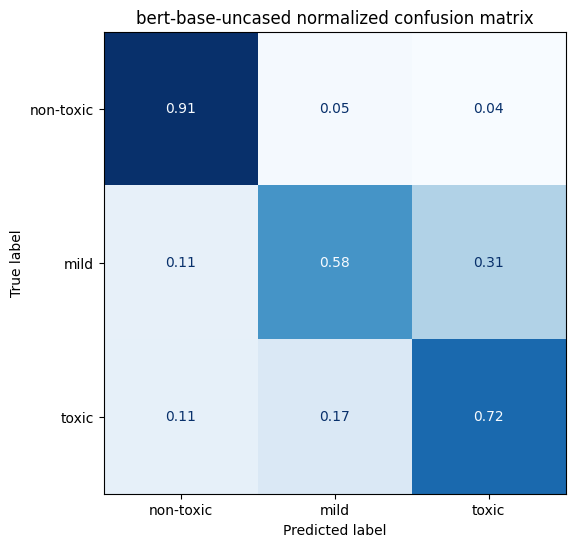

In [ ]:
print_confusion_matrix('bert-base-uncased', test['target'], test['bert-base-predictions'])

In [ ]:
print_classification_report(test['target'], test['bert-base-predictions'])

              precision    recall  f1-score   support

   non-toxic       0.91      0.91      0.91       353
        mild       0.60      0.58      0.59       118
       toxic       0.70      0.72      0.71       167

    accuracy                           0.80       638
   macro avg       0.74      0.73      0.74       638
weighted avg       0.80      0.80      0.80       638



## BERT (Large-uncased)

In [ ]:
print_default_confusion_matrix('bert-large-uncased', test['target'], test['bert-large-predictions'])

bert-large-uncased confusion matrix log:
[[330  11  12]
 [ 11  77  30]
 [ 15  38 114]]


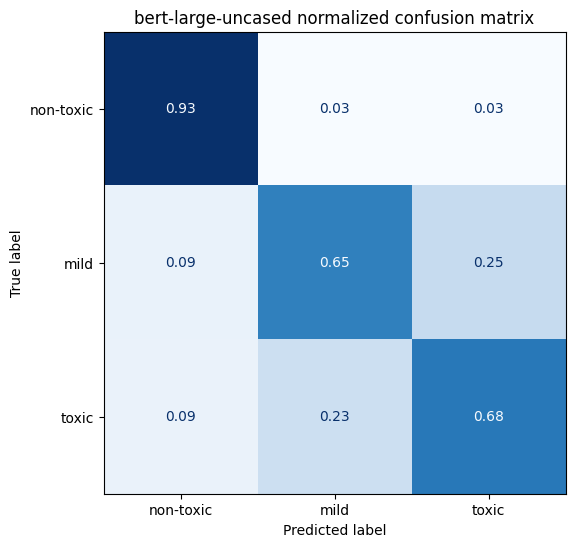

In [ ]:
print_confusion_matrix('bert-large-uncased', test['target'], test['bert-large-predictions'])

In [ ]:
print_classification_report(test['target'], test['bert-large-predictions'])

              precision    recall  f1-score   support

   non-toxic       0.93      0.93      0.93       353
        mild       0.61      0.65      0.63       118
       toxic       0.73      0.68      0.71       167

    accuracy                           0.82       638
   macro avg       0.76      0.76      0.76       638
weighted avg       0.82      0.82      0.82       638



## GPT-3 (davinci-002)

In [ ]:
print_default_confusion_matrix('gpt-3-davinci-002', test['target'], test['gpt-3-predictions'])

gpt-3-davinci-002 confusion matrix log:
[[325  17  11]
 [  3  70  45]
 [ 12  21 134]]


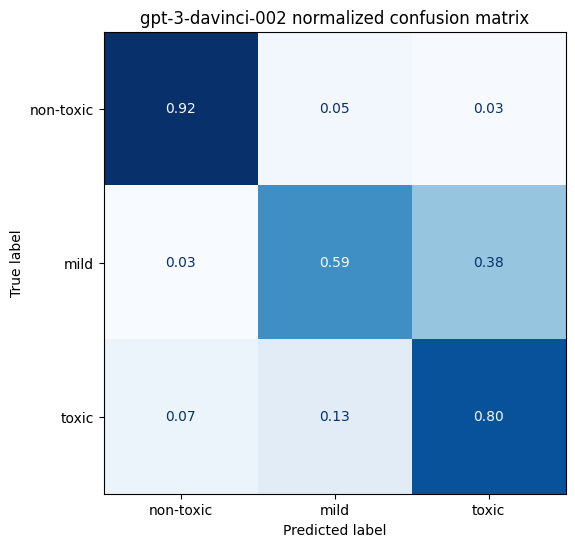

In [ ]:
print_confusion_matrix('gpt-3-davinci-002', test['target'], test['gpt-3-predictions'])

In [ ]:
print_classification_report(test['target'], test['gpt-3-predictions'])

              precision    recall  f1-score   support

   non-toxic       0.96      0.92      0.94       353
        mild       0.65      0.59      0.62       118
       toxic       0.71      0.80      0.75       167

    accuracy                           0.83       638
   macro avg       0.77      0.77      0.77       638
weighted avg       0.83      0.83      0.83       638

